# Trabajo Final - Aprendizaje Profundo

## Ejercicio 2 

### Alumno: Domenje Carlos



### ✒️ Enunciado

2) Utilizando el mismo dataset que en el link anterior, diseñar una red neuronal que haga un
overfitting sobre el dataset. ¿Cómo saben que la red neuronal está haciendo overfitting?
Agregar regularización y encontrar los parámetros correctos para lograr un buen fit. Explicar
el procedimiento realizado.

### 💾 Imports de librerias necesarias 


In [1]:

import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,plot_confusion_matrix,roc_auc_score, classification_report, confusion_matrix, precision_recall_curve, auc
np.random.seed(20)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import sklearn.metrics as metrics
import torch
from torch.utils.data import DataLoader, Dataset


### 📟 Lectura del Dataset



In [2]:
dataset = pd.read_csv('./data/dataset_1.csv')

In [3]:
# Observación estadística de los datos
dataset.describe()

,# X,Y
count,10000.000000,10000.000000
mean,1.000000,2.029839
std,0.577437,2.303106
min,0.000000,-0.897512
25%,0.500000,0.383598
50%,1.000000,1.105209
75%,1.500000,3.831945
max,2.000000,8.912945


In [4]:
# Chequeo si hay datos nulos
dataset.isnull().sum()

# X    0
Y      0
dtype: int64

In [5]:
# Cambio el nombre de la columna # X solo por X
dataset.rename(columns = {'# X':'X'}, inplace = True)

dataset.describe()

,X,Y
count,10000.000000,10000.000000
mean,1.000000,2.029839
std,0.577437,2.303106
min,0.000000,-0.897512
25%,0.500000,0.383598
50%,1.000000,1.105209
75%,1.500000,3.831945
max,2.000000,8.912945


#### Separación de datos para entrenamiento y test

In [6]:
X = dataset[["X"]]
y = dataset[["Y"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=50)

In [7]:
class DefineDataset(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [8]:
# Chequeamos la presencia relativa de cada clase y el tamaño de los nuevos datasets
print('Datos para Entrenamiento:',X_train.shape)
print('Datos para Testeo:',X_test.shape)
print('Datos para Entrenamiento:',y_train.shape)
print('Datos para Testeo:',y_test.shape)
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)
training = DefineDataset(X_train,y_train)
validation = DefineDataset(X_test,y_test)

train_dataloader = DataLoader(training, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(validation, batch_size=64, shuffle=True)

Datos para Entrenamiento: (7500, 1)
Datos para Testeo: (2500, 1)
Datos para Entrenamiento: (7500, 1)
Datos para Testeo: (2500, 1)


### Definición de clase para aplicar MiniBatch

In [9]:
class NNet(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.linear_1 = torch.nn.Linear(in_features=1, out_features=50, bias=True)
        self.relu_1 = torch.nn.ReLU()
        self.linear_2 = torch.nn.Linear(in_features=50, out_features=100, bias=True)
        self.relu_2 = torch.nn.ReLU()
        self.linear_3 = torch.nn.Linear(in_features=100, out_features=200, bias=True)
        self.relu_3 = torch.nn.ReLU()
        self.linear_4 = torch.nn.Linear(in_features=200, out_features=100, bias=True)
        self.relu_4 = torch.nn.ReLU()
        self.linear_5 = torch.nn.Linear(in_features=100, out_features=75, bias=True)
        self.relu_5 = torch.nn.ReLU()
        self.output = torch.nn.Linear(in_features=75, out_features=1, bias=True)

    def forward(self, x): 
        x = self.linear_1(x) 
        x = self.relu_1(x) 
        x = self.linear_2(x) 
        x = self.relu_2(x) 
        x = self.linear_3(x)
        x = self.relu_3(x)
        x = self.linear_4(x)
        x = self.relu_4(x)
        x = self.linear_5(x)
        x = self.relu_5(x)
        x = self.output(x) 
        return x

In [10]:
nnet = NNet()
optimizer = torch.optim.Adam(nnet.parameters(), lr=0.005)
loss_function = torch.nn.MSELoss(reduction="sum")

In [11]:
device = ""
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

print(device)

cpu


In [12]:
nnet.to(device)

loss_list = list()
valid_loss_list = list()
train_auc = list()

for epoch in range(800): 
    
    running_loss = 0
    running_valid_loss = 0
    running_y_score = list()
    running_y_label = list()

    nnet.train()
    # Recorrido por los batchs
    for i, data in enumerate(train_dataloader):
        
        X_batch, y_batch = data
        X_batch = X_batch.to(device).float()
        y_batch = y_batch.to(device).float()

        # Forward propagation
        optimizer.zero_grad() 
        y_batch_score = nnet(X_batch).reshape(-1)
        

        # Back Propagation
        loss = loss_function(y_batch_score, y_batch)
        loss.backward()

        # Se actualizan los parametros
        optimizer.step()

        running_loss += loss.item()
        running_y_score += list(y_batch_score.detach().cpu().numpy())
        running_y_label += list(y_batch.detach().cpu().numpy())
    
    loss_list.append(running_loss)
    
    nnet.eval()
    with torch.no_grad():
        for i, data in enumerate(valid_dataloader): 
            X_valid_batch, y_valid_batch = data
            X_valid_batch = X_valid_batch.to(device).float()
            y_valid_batch = y_valid_batch.to(device).float()

            y_valid_batch_score = nnet(X_valid_batch).reshape(-1)
            valid_loss = loss_function(y_valid_batch_score, y_valid_batch) 

            running_valid_loss += valid_loss.item()
    
    valid_loss_list.append(running_valid_loss)
  

#### Utilización de mini batch y entrenamiento del modelo

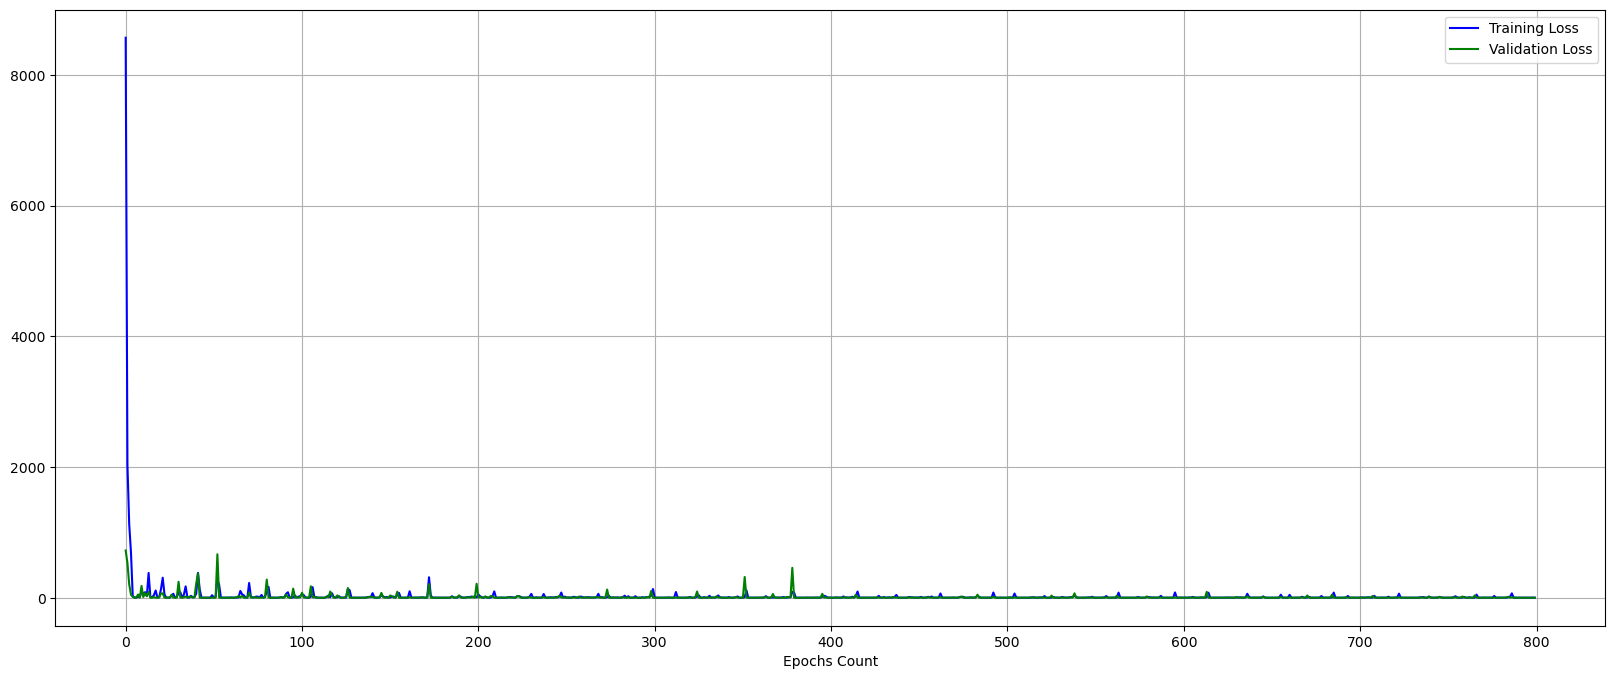

In [13]:

plt.figure(figsize=(20,8))
plt.grid(True, which='both')
plt.axis()
x = range(0, len(loss_list))
plt.plot(x,loss_list, label='Training Loss',color='b')
plt.plot(x,valid_loss_list, label='Validation Loss',color='g')
plt.xlabel("Epochs Count")
plt.legend()



#### Resultado del testing

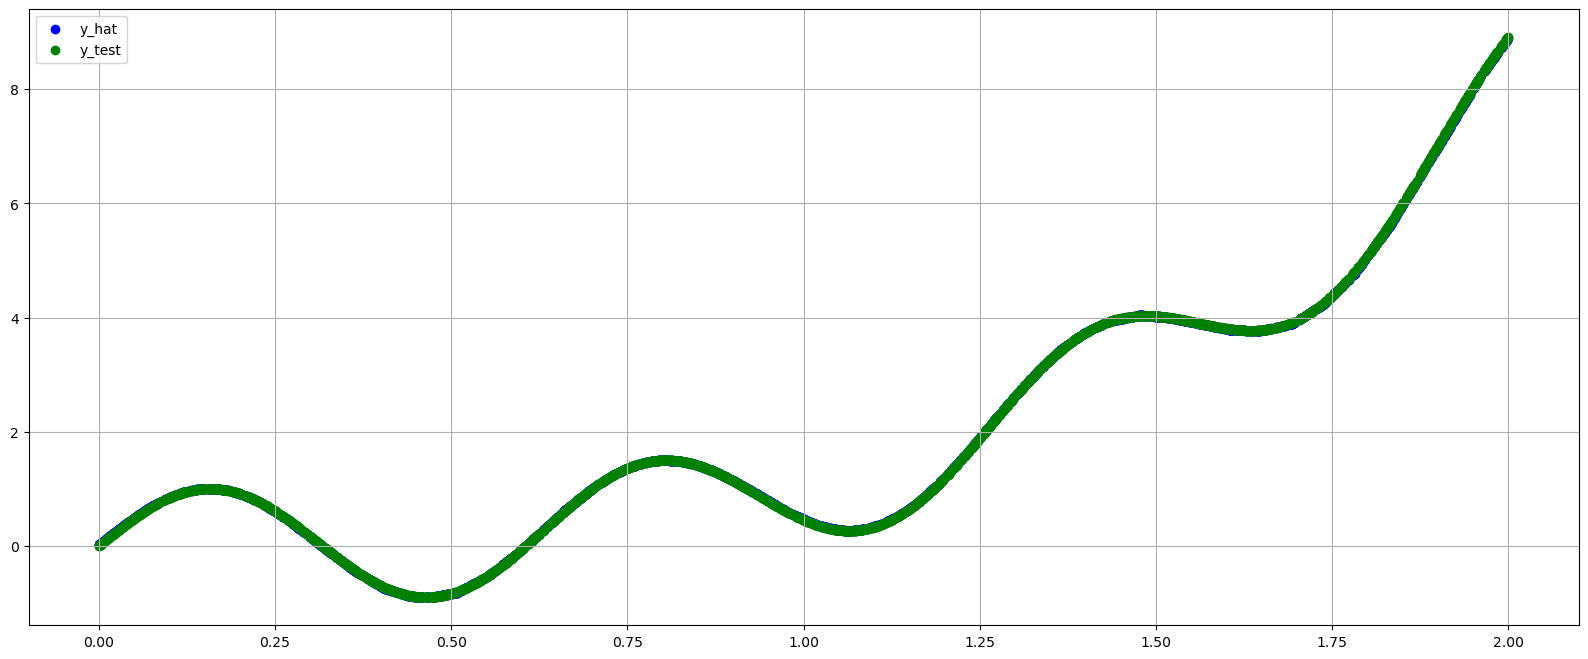

In [14]:


t = torch.from_numpy(X_test)
with torch.no_grad():
  
    y_hat = nnet(t.to(device).float())


plt.figure(figsize=(20,8))
y_hat = y_hat.cpu()
plt.grid(True, which='both')
plt.axis()
plt.scatter(X_test,y_hat, label='y_hat',color='b')
plt.scatter(X_test,y_test, label='y_test',color='g')
plt.legend()

#### Métricas

In [15]:
print("R2 score para testing: {}".format(r2_score(y_test, y_hat)))


R2 score para testing: 0.9999865765552417


### Conclusion

Como puede observarse en las graficas, se logró obtener un buen resultado en el modelado, ambas graficas son practicamente las mismas. 
El bias bajo es debido a la cantidad de capas y numero de neuronas, es decir el tamaño de las capas. 
Por último podemos ver que la métrica R2 tenemos un valor practicamente sin errores, por lo que obtuvimos un muy buen modelo.



### Regularización

In [16]:

train_dataloader = DataLoader(training, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(validation, batch_size=64, shuffle=True)



In [17]:
class NNet(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.linear_1 = torch.nn.Linear(in_features=1, out_features=50, bias=True)
        self.relu_1 = torch.nn.ReLU()
        self.linear_2 = torch.nn.Linear(in_features=50, out_features=100, bias=True)
        self.relu_2 = torch.nn.ReLU()
        self.linear_3 = torch.nn.Linear(in_features=100, out_features=200, bias=True)
        self.relu_3 = torch.nn.ReLU()
        self.linear_4 = torch.nn.Linear(in_features=200, out_features=100, bias=True)
        self.relu_4 = torch.nn.ReLU()
        self.linear_5 = torch.nn.Linear(in_features=100, out_features=75, bias=True)
        self.relu_5 = torch.nn.ReLU()
        self.output = torch.nn.Linear(in_features=75, out_features=1, bias=True)
        self.dropout = torch.nn.Dropout(0.25)

    def forward(self, x): 
       
        x = self.linear_1(x)
        x = self.dropout(x)
        x = self.relu_1(x) 

        x = self.linear_2(x) 
        x = self.dropout(x)
        x = self.relu_2(x) 

        x = self.linear_3(x)
        x = self.dropout(x)
        x = self.relu_3(x)

        x = self.linear_4(x)
        x = self.dropout(x)
        x = self.relu_4(x)

        x = self.linear_5(x)
        x = self.dropout(x)
        x = self.relu_5(x)

        x = self.output(x) 
        return x

In [18]:
nnet_with_dropout = NNet()
optimizer = torch.optim.Adam(nnet_with_dropout.parameters(), lr=0.005)
loss_function = torch.nn.MSELoss(reduction="sum")

In [19]:
device = ""
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

print(device)

cpu


In [20]:
nnet_with_dropout.to(device)

loss_list_with_dropout = list()
valid_loss_list_with_dropout = list()

for epoch in range(100): 
    
    running_loss = 0
    running_valid_loss = 0
    running_y_score = list()
    running_y_label = list()

    nnet_with_dropout.train()

    for i, data in enumerate(train_dataloader):
       
        X_batch, y_batch = data
        X_batch = X_batch.to(device).float()
        y_batch = y_batch.to(device).float()

        # forward
        optimizer.zero_grad() 
        y_batch_score = nnet_with_dropout(X_batch).reshape(-1)
    

        # backpropagation
        loss = loss_function(y_batch_score, y_batch)
        loss.backward() # hacer gradientes de score

        # actualizar parametros
        optimizer.step()

        running_loss += loss.item()
        running_y_score += list(y_batch_score.detach().cpu().numpy())
        running_y_label += list(y_batch.detach().cpu().numpy())
    
    loss_list_with_dropout.append(running_loss)
    
    nnet_with_dropout.eval()
    with torch.no_grad():
        for i, data in enumerate(valid_dataloader): 
            X_valid_batch, y_valid_batch = data
            X_valid_batch = X_valid_batch.to(device).float()
            y_valid_batch = y_valid_batch.to(device).float()

            # forward
            y_valid_batch_score = nnet_with_dropout(X_valid_batch).reshape(-1)
            valid_loss = loss_function(y_valid_batch_score, y_valid_batch) 

            running_valid_loss += valid_loss.item()
    
    # Calcular las metricas
    valid_loss_list_with_dropout.append(running_valid_loss)
    print("Epoch:", epoch, "\tTraining Loss:", running_loss, "\tValidation Loss:", running_valid_loss)

Epoch: 0 	Training Loss: 12226.674008369446 	Validation Loss: 1189.8648787736893
Epoch: 1 	Training Loss: 7412.93351817131 	Validation Loss: 973.8648490905762
Epoch: 2 	Training Loss: 6239.110118150711 	Validation Loss: 3904.102587223053
Epoch: 3 	Training Loss: 5434.990213394165 	Validation Loss: 2234.42435836792
Epoch: 4 	Training Loss: 5247.366245746613 	Validation Loss: 1939.1892304420471
Epoch: 5 	Training Loss: 5255.94530248642 	Validation Loss: 622.975758433342
Epoch: 6 	Training Loss: 4132.378974914551 	Validation Loss: 914.1755645871162
Epoch: 7 	Training Loss: 4424.0553143024445 	Validation Loss: 2379.595845580101
Epoch: 8 	Training Loss: 3917.910723209381 	Validation Loss: 1225.7415112257004
Epoch: 9 	Training Loss: 3831.4196588993073 	Validation Loss: 3225.837944149971
Epoch: 10 	Training Loss: 3739.067690849304 	Validation Loss: 959.7635499238968
Epoch: 11 	Training Loss: 3228.660364627838 	Validation Loss: 560.7795571237803
Epoch: 12 	Training Loss: 3358.7336769104004 	Va

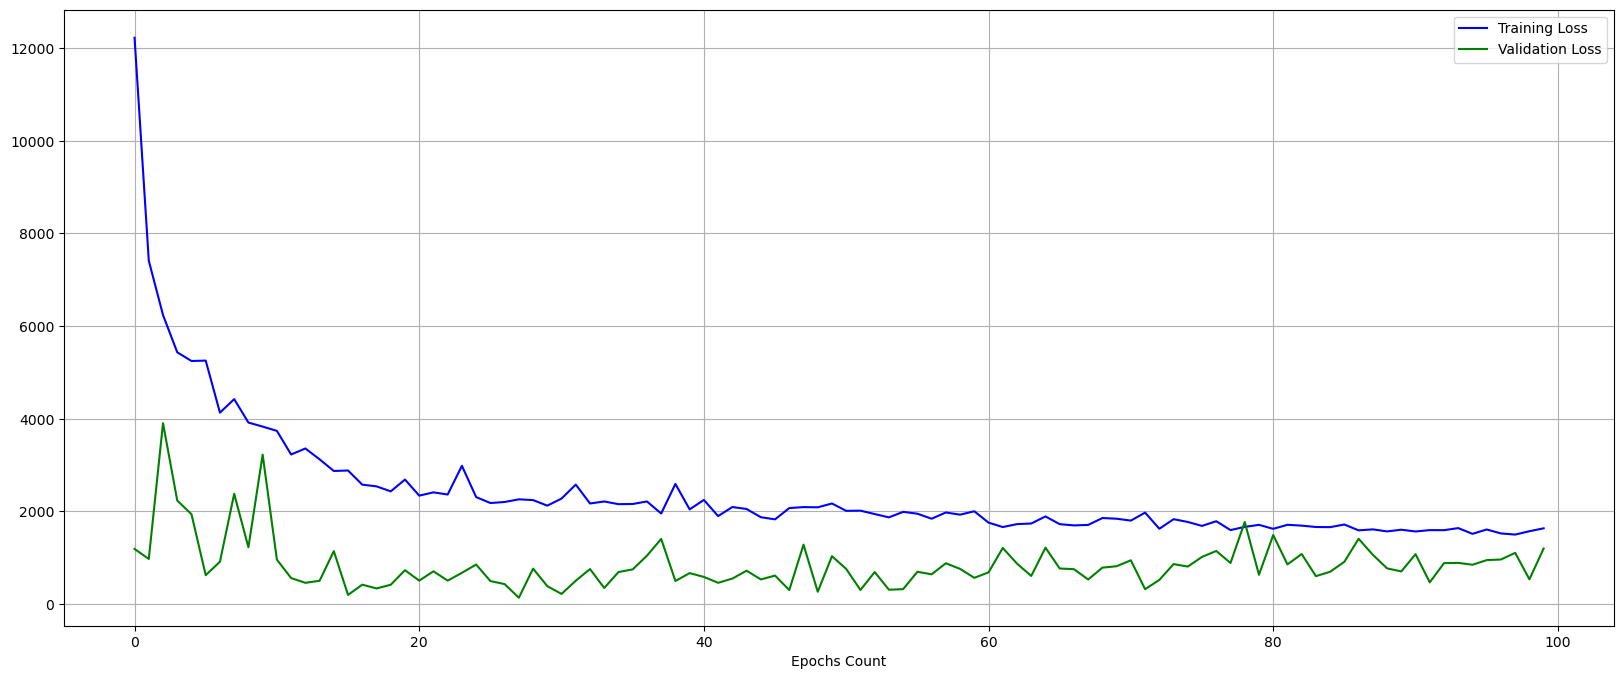

In [21]:


plt.figure(figsize=(20,8))
plt.grid(True, which='both')
plt.axis()
x = range(0, len(loss_list_with_dropout))
plt.plot(x,loss_list_with_dropout, label='Training Loss',color='b')
plt.plot(x,valid_loss_list_with_dropout, label='Validation Loss',color='g')
plt.xlabel("Epochs Count")
plt.legend()

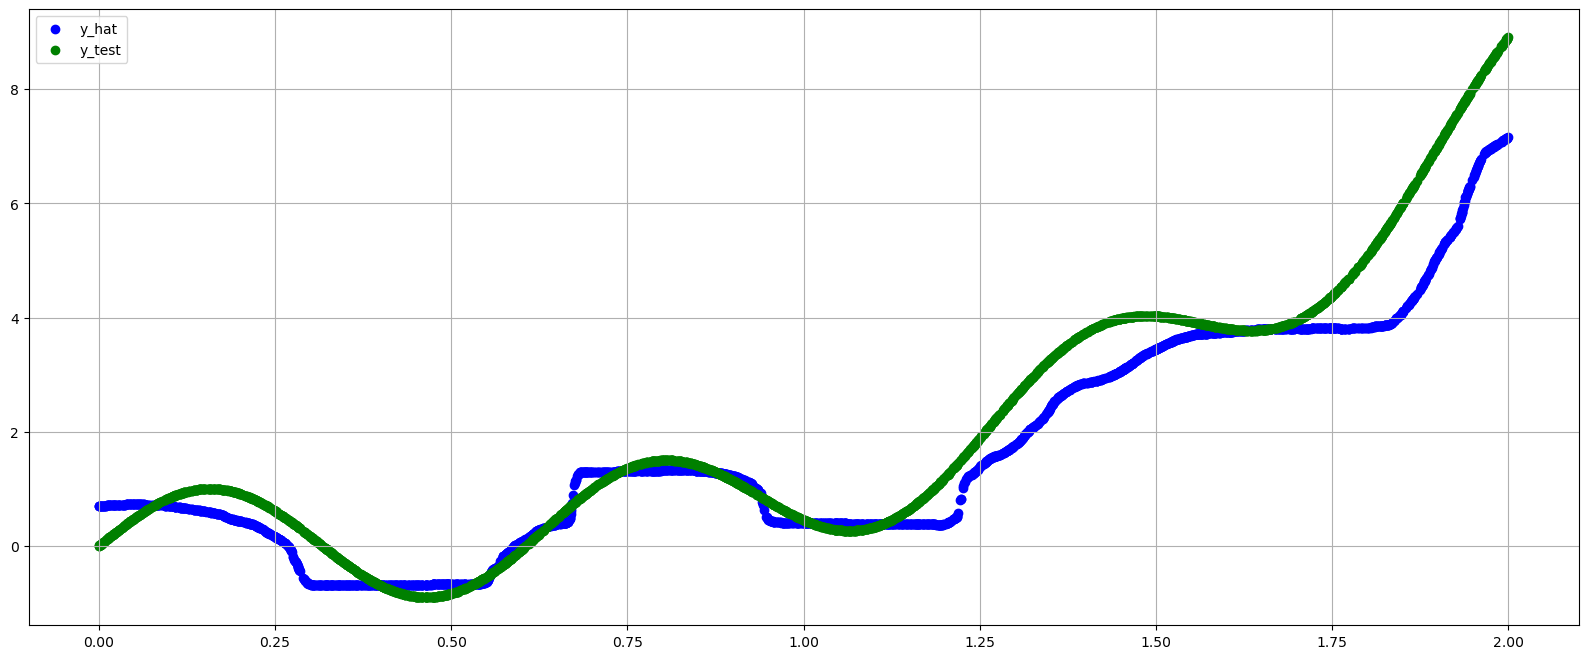

In [22]:
t = torch.from_numpy(X_test)
with torch.no_grad():
    # forward
    y_hat_ej2_emb = nnet_with_dropout(t.to(device).float())


plt.figure(figsize=(20,8))
y_hat_ej2_emb = y_hat_ej2_emb.cpu()
plt.grid(True, which='both')
plt.axis()
plt.scatter(X_test,y_hat_ej2_emb, label='y_hat',color='b')
plt.scatter(X_test,y_test, label='y_test',color='g')
plt.legend()

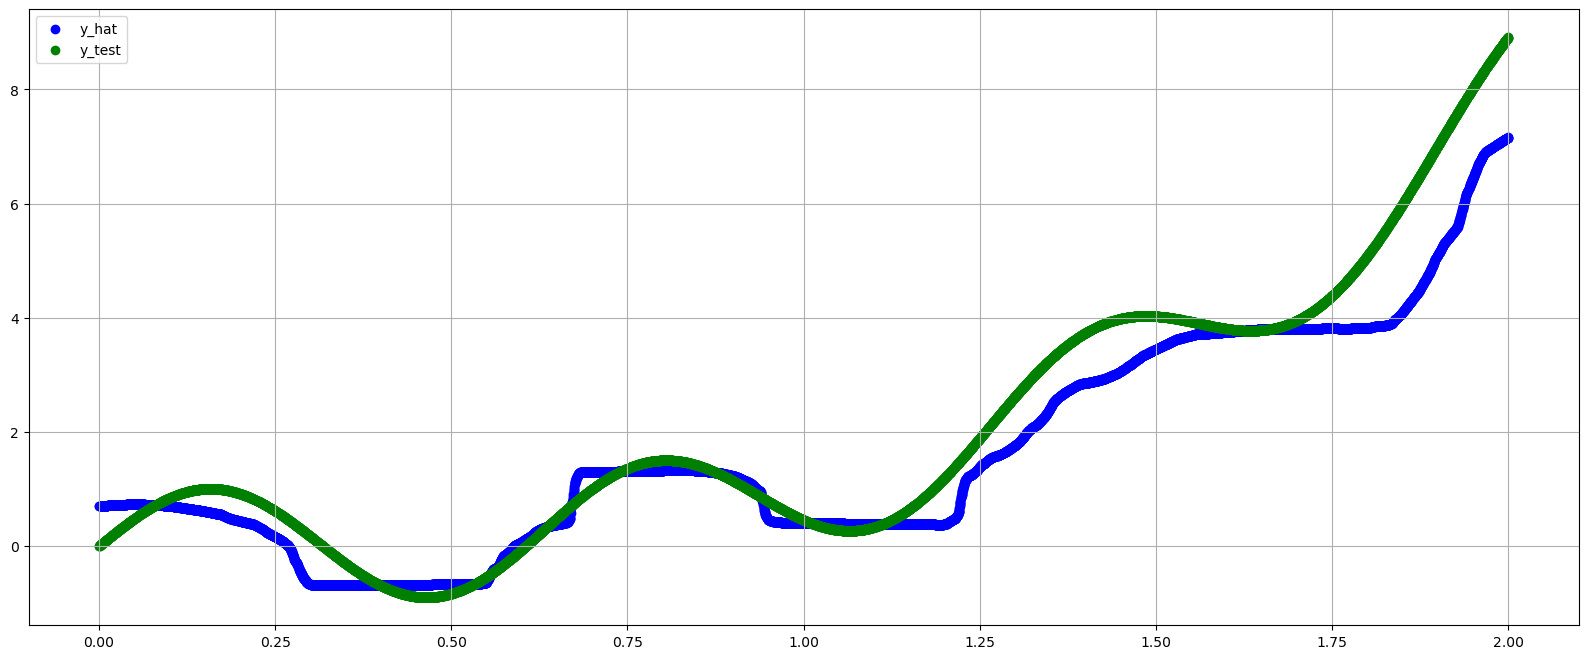

In [23]:
t = torch.from_numpy(X_train)
with torch.no_grad():
    # forward
    y_train_hat_emb = nnet_with_dropout(t.to(device).float())
    


plt.figure(figsize=(20,8))
y_train_hat_emb = y_train_hat_emb.cpu()
plt.grid(True, which='both')
plt.axis()
plt.scatter(X_train,y_train_hat_emb, label='y_hat',color='b')
plt.scatter(X_train,y_train, label='y_test',color='g')
plt.legend()



In [24]:
r2_score(y_test, y_hat_ej2_emb)

0.909721621377855

In [25]:
r2_score(y_train, y_train_hat_emb)

0.9064729502704691